# Regresión logística con una perspectiva de Redes Neuronales

En este ejercicio construirá un clasificador de regresión logística. En este cuaderno encontrará la guía para hacerlo desde una perspectiva de redes neuronales, ganando una intuición sobre lo que es el aprendizaje computacional y el deep learning.

**Instrucciones:**
- No utilize bucles-for/while en su código, a menos que se le pida hacerlo explícitamente.

**Tras este taller usted va a ser capaz de:**
- Construir la arquitectura general de un algoritmo de aprendizaje, incluyendo:
    - Inicialización de parámetros
    - Calcular la función de coste y su gradiente
    - Utilizar un algoritmo de optimización (descenso en la dirección del gradiente, GD) 
- Reunir todas las tres funciones en un modelo principal en el orden adecuado.

Manos a la obra!!

## 1 - Paquetes ##

Primero, importamos los paquetes que vamos a necesitar a lo largo de este taller. 
- [numpy](www.numpy.org) paquete básico para ciencias computacionales con Python.
- [h5py](http://www.h5py.org) paquete para interactuar con un conjunto de datos guardado en un archivo de tipo H5.
- [matplotlib](http://matplotlib.org) librería para graficar en Python.
- [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) usados para probar el modelo con sus propias imagenes al final del taller

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

C:\Users\hernyatt\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Enunciado del problema ##

**Enunciado**: El siguiente conjunto de datos está disponible ("data.h5") con la siguiente información:
    - un conjunto de entrenamiento m_train con imagenes etiquetadas como gato (y=1) o no-gato (y=0)
    - un conjunto de prueba m_test con imagenes etiquetadas como cat/gato o non-cat/no-gato
    - cada imagen tiene dimensiones (num_px, num_px, 3) donde 3 es para los canales RGB (nótese que cada imagen es cuadrada (altura = num_px) y (ancho = num_px).

Usted debe construir un algoritmo simple de reconocimiento de imagenes que pueda clasificar correctamente las imagenes como gato o no-gato.

Primero, examinemos los datos. Cargue el archivo con el siguiente código.

In [2]:
# Carga de datos (gato/no-gato)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
clases=["no-gato", "gato"]

Comprobamos las dimensiones de una observación

In [3]:
train_set_x_orig[0].shape

(64, 64, 3)

Añadimos "_orig" al final de los datos de entrenamiento y prueba porque vamos a pre-procesarlos. Luego de esto, vamos a obtener un train_set_x y un test_set_x (nótese que las etiquetas de train_set_y y test_set_y no necesitan ningún pre-procesamiento).

Cada observación (línea) del train_set_x_orig y del test_set_x_orig es un arreglo representando una imagen. Se puede visualizar cada observación mediante el siguiente código. Puede cambiar el valor del `indice` para visualizar imagenes distintas. 

La imagen #60, es un 'gato'


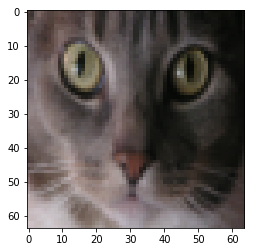

In [4]:
# Ejemplo de una imagen
indice = 60
plt.imshow(train_set_x_orig[indice])
print ("La imagen #" + str(indice) + ", es un '" + str(clases[np.squeeze(train_set_y[:, indice])]) + "'" )

Muchos fallos/bugs del código en deep learning ocurren por tener dimensiones de la matriz/vector que no encajan. Si puede mantener las dimensiones correctas podrá evitar tener que dedicar tiempo a corregir estos fallos. 

**Ejercicio:** Encuentre los valores para:
    - m_train (número de ejemplos de entrenamiento)
    - m_test (número de ejemplos de prueba)
    - num_px (= altura = ancho de la imagen)
Recuerde que `train_set_x_orig` es un arreglo numpy de dimensiones (m_train, num_px, num_px, 3). De esta manera, puede acceder a `m_train` escribiendo `train_set_x_orig.shape[0]`.

In [5]:
### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 3 líneas de código)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]
### TERMINE EL CÓDIGO AQUÍ ###

print ("Número de ejemplos de entrenamiento: m_train = " + str(m_train))
print ("Número de ejemplos de prueba: m_test = " + str(m_test))
print ("Altura/Ancho de cada imagen: num_px = " + str(num_px))

print ("Cada imagen es de tamaño: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("Dimensión del train_set_x: " + str(train_set_x_orig.shape))
print ("Dimensión del train_set_y: " + str(train_set_y.shape))
print ("Dimensión del test_set_x: " + str(test_set_x_orig.shape))
print ("Dimensión del test_set_y: " + str(test_set_y.shape))

Número de ejemplos de entrenamiento: m_train = 209
Número de ejemplos de prueba: m_test = 50
Altura/Ancho de cada imagen: num_px = 64
Cada imagen es de tamaño: (64, 64, 3)
Dimensión del train_set_x: (209, 64, 64, 3)
Dimensión del train_set_y: (1, 209)
Dimensión del test_set_x: (50, 64, 64, 3)
Dimensión del test_set_y: (1, 50)


**Salida esperada para m_train, m_test y num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


Es recomendable ahora re-dimensionar las imagenes de tamaño (num_px, num_px, 3) en un arreglo numpy de dimensión (num_px $*$ num_px $*$ 3, 1). Luego, los conjuntos de entrenamiento y prueba serán un arreglo numpy donde cada columna representa una imagen (aplanada). Deberían haber m_train y m_test columnas.

**Ejercicio:** Re-dimensione los conjuntos de datos de entrenamiento y prueba para que las imagenes de tamaño (num_px, num_px, 3) sean aplanadas en vectores de dimensión (num\_px $*$ num\_px $*$ 3, 1).

Ayuda. Cuando se quiere aplanar una matriz X de dimensión (a,b,c,d) en una matriz X_flatten de dimensión (b$*$c$*$d, a) se puede usar: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T es la transpuesta de X
```

In [6]:
# Re-dimensione los ejemplos de entrenamiento y prueba

### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### TERMINE EL CÓDIGO AQUÍ ###

print ("Dimensión del train_set_x_flatten: " + str(train_set_x_flatten.shape))
print ("Dimensión del train_set_y: " + str(train_set_y.shape))
print ("Dimensión del test_set_x_flatten: " + str(test_set_x_flatten.shape))
print ("Dimensión del test_set_y: " + str(test_set_y.shape))
print ("Chequeo luego del re-dimensionamiento: " + str(train_set_x_flatten[0:5,0]))

Dimensión del train_set_x_flatten: (12288, 209)
Dimensión del train_set_y: (1, 209)
Dimensión del test_set_x_flatten: (12288, 50)
Dimensión del test_set_y: (1, 50)
Chequeo luego del re-dimensionamiento: [17 31 56 22 33]


**Salida esperada**: 

<table style="width:55%">
  <tr>
    <td>**Dimensión train_set_x_flatten**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**Dimensión train_set_y**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**Dimensión test_set_x_flatten**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**Dimensión test_set_y**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**Chequeo tras el re-dimensionamiento**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Las imagenes a color son comúnmente representadas mediante los tres canales rojo, verde y azul (RGB) para cada pixel, de tal manera que a cada pixel le corresponde un vector de tres números en el rango de 0 a 255.

Un paso muy común en el pre-procesamiento de datos en machine learning es el de estandarizar el conjunto de datos multivariado, es decir, restando la media de cada vector a cada ejemplo, y dividiendo por la desviación estandar del vector. En este caso del tratamiento de imagenes, es más simple y conveniente tan solo dividir todas las filas del conjunto de datos por 255 (el valor máximo de un canal RGB).

<!-- Durante el entrenamiento del modelo, se multiplican pesos y se suman sesgos a algunos inputs iniciales para observar activaciones neuronales. Luego se retro-propaga a partir de los gradientes para entrenar el modelo. Pero es importante que cada patrón del input tenga un rango similar para que los gradientes no exploten. Más adelante se profundizará en esto. !--> 

Normalizemos los datos.

In [7]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**Recapitulemos:**

Pasos comunes para el pre-procesamiento de un nuevo conjunto de datos:
- Examinar las dimensiones del problema (m_train, m_test, num_px, ...)
- Re-dimensionar los conjuntos de datos para que cada ejemplo sea un vector de tamaño (num_px \* num_px \* 3, 1)
- Normalizar o estandarizar los datos

## 3 - Arquitectura general de un algoritmo de aprendizaje ##

Llegó el momento de diseñar un algoritmo simple para distinguir imagenes de gatos y de aquello que no son gatos.

Debe constuir un modelos de regresión logística, desde una perspectiva de Redes Neuronales.

**Formulación del algoritmo**:

Para un ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoide(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

El coste se calcula sumando sobre todos los ejemplos de entrenamiento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Paso a paso**:
En este ejercicio, se deben dar los siguientes pasos: 
    - Inicializar los parámetros del modelo
    - Aprender los parámetros del modelo a partir de la minimización del coste  
    - Utilizar los parámetros aprendidos para hacer predicciones (sobr el conjunto de prueba)
    - Analizar los resultados y concluir

## 4 - Construyendo las partes del algoritmo ## 

Los pasos principales para construir una red neuronal son: 
1. Definir la estructura del modelo (tal como el número de patrones en el input) 
2. Inicializar los parámetros del modelo
3. Bucle:
    - Calcular la pérdida actual (propagación hacia delante)
    - Calcular el gradiente actual (retro-propagación)
    - Actualizar los parámetros (descenso en la dirección del gradiente)

Se suele construir 1-3 de manera separada e integrarlos en una función que llamaremos `model()`.

### 4.1 - Funciones de ayuda

**Ejercicio**: Utilizando su código del Taller_1 "IntroPython_numpy", implemente `sigmoid()`. Como se puede ver en la figura arriba, se debe computar $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ para predecir. Para ello puede utilizar np.exp().

In [8]:
# FUNCIÓN A CALIFICAR: sigmoid

def sigmoid(z):
    """
    Calcule el sigmoide de z
    Input:
    z: Un escalar o arreglo numpy de cualquier tamaño
    Output:
    s: sigmoid(z)
    """

    ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
    s = 1/(1+ np.exp(-z))
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    return s

In [9]:
print ("sigmoide([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoide([0, 2]) = [0.5        0.88079708]


**Salida esperada**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Inicialización de parámteros

**Ejercicio:** Implemente la inicialización de parámetros. Se tiene un vector w de ceros. Si no sabe qué función de numpy puede utilizar, puede buscar np.zeros() en la documentación de la biblioteca Numpy.

In [10]:
# FUNCIÓN A CALIFICAR: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    Esta función crea un vector de ceros de dimensión (dim, 1) para w e inicializa b a 0.
    Input:
    dim: tamaño del vector w (número de parámetros para este caso)
    Output:
    w: vector inicializado de tamaño (dim, 1)
    b: escalar inicializado (corresponde con el sesgo)
    """
    
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    w = np.zeros((dim, 1))    
    b = 0
    ### TERMINE EL CÓDIGO AQUÍ ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Salida esperada**: 


<table style="width:25%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Para inputs de imagen, w será de tamaño (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Propagación hacia delante y hacia atrás

Una vez los parámetros están inicializados, se pueden implementar los pasos de propagación hacia "delante" y hacia "atrás" para el aprendizaje de los parámetros.

**Ejercicio:** Implemente la función `propagate()` que calcula la función de coste y su gradiente.

**Ayuda**:

Propagación hacia delante:
- Se tiene X
- Se calcula $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Se calcula la función de coste/pérdida: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Se pueden usar las siguientes fórmulas: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
# FUNCIÓN A CALIFICAR: propagate

def propagate(w, b, X, Y):
    """
    Implemente la función de coste y su gradiente para la propagación
    Input:
    w: pesos, un arreglo numpy de tamaño (num_px * num_px * 3, 1)
    b: sesgo, un escalar
    X: datos de tamaño (num_px * num_px * 3, número de ejemplos)
    Y: vector de etiquetas observadas (0 si es no-gato, 1 si es gato) de tamaño (1, número de ejemplos)
    Output:
    coste: coste negativo de log-verosimilitud para la regresión logística
    dw: gradiente de la pérdida con respecto a w, con las mismas dimensiones que w
    db: gradiente de la pérdida con respecto a b, con las mismas dimensiones que b
    
    (Sugerencia: escriba su código paso a paso para la propagación. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # PROPAGACIÓN HACIA DELANTE 
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
    A = sigmoid((np.dot(w.T,X)+b))                           # compute la activación
    cost = np.sum (-(Y*np.log(A) + (1-Y)*np.log(1-A))/m )    # compute el coste
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # RETRO-PROPAGACIÓN (PROPAGACIÓN HACIA ATRÁS)
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
    dw = (1/m) * np.dot(X,(A-Y).T)
    db = (1/m) * np.sum(A-Y)
    ### TERMINE EL CÓDIGO AQUÍ ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [13]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("coste = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
coste = 5.801545319394553


**Salida esperada**: 

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimización
- Se tienen los parámetros inicializados.
- También se tiene el código para calcular la función de coste y su gradiente.
- Ahora se quieren actualizar los parámetros utilizando el descenso en la dirección del gradiente (GD).

**Ejercicio:** Escriba la función de optimización. EL objetivo es el de aprender $w$ y $b$ minimizando la función de coste $J$. Para un parámetro $\theta$, la regla de actualización es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es la tasa de aprendizaje.

In [14]:
# FUNCIÓN A CALIFICAR: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Esta función optimiza w y b implementando el algoritmo de GD
    Input:
    w: pesos, un arreglo numpy de tamaño (num_px * num_px * 3, 1)
    b: sesgo, un escalar
    X: datos de tamaño (num_px * num_px * 3, número de ejemplos)
    Y: vector de etiquetas observadas (0 si es no-gato, 1 si es gato) de tamaño (1, número de ejemplos)
    num_iterations: número de iteracionespara el bucle de optimización
    learning_rate: tasa de aprendizaje para la regla de actualización del GD
    print_cost: True para imprimir la pérdida cada 100 iteraciones
    Output:
    params: diccionario con los pesos w y el sesgo b
    grads: diccionario con los gradientes de los pesos y el sesgo con respecto a la función de pérdida
    costs: lista de todos los costes calculados durante la optimización, usados para graficar la curva de aprendizaje.
    
    Sugerencia: puede escribir dos pasos e iterar sobre ellos:
        1) Calcule el coste y el gradiente de los parámetros actuales. Use propagate().
        2) Actualize los parámetros usando la regla del GD para w y b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Computación del coste y el gradiente (≈ 1-4 líneas de código)
        ### EMPIEZE EL CÓDIGO AQUÍ ### 
        grads, cost = propagate(w, b, X, Y)
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Recupere las derivadas de grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Actualize la regla (≈ 2 líneas de código)
        ### EMPIEZE EL CÓDIGO AQUÍ ###
        w = w- learning_rate*dw
        b = b- learning_rate*db
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Guarde los costes
        if i % 100 == 0:
            costs.append(cost)
        
        # Se muestra el coste cada 100 iteraciones de entrenamiento
        if print_cost and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Salida esperada**:  

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**Ejercicio:** La función anterior aprende los parámetros w y b, que se pueden usar para predecir las etiquetas para el conjunto de datos X. Ahora implemente la función `predict()`. Hay dos pasos para calcular las predicciones:

1. Calcule $\hat{Y} = A = \sigma(w^T X + b)$

2. Convierta a 0 las entradas de a (si la activación es <= 0.5) o 1 (si la activación es > 0.5), guarde las predicciones en un vector `Y_prediction`. Si lo desea, puede usar un `if`/`else` en un bucle `for`, aunque también hay una manera de vectorizarlo. 

In [16]:
# FUNCIÓN A CALIFICAR: predict

def predict(w, b, X):
    '''
    Prediga si una etiqueta es 0 o 1 usando los parámetros de regresión logística aprendidos (w, b)
    Input:
    w: pesos, un arreglo numpy de tamaño (num_px * num_px * 3, 1)
    b: sesgo, un escalar
    X: datos de tamaño (num_px * num_px * 3, número de ejemplos)
    Output:
    Y_prediction: vector con todas las predicciones (0/1) para los ejemplos en X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute el vector "A" prediciendo las probabilidades de que la imagen contenga un gato
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    A = sigmoid((np.dot(w.T,X)+b))
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    for i in range(A.shape[1]):
        
        # Convierta las probabilidades A[0,i] a predicciones p[0,i]
        ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1-4 líneas de código)
        Y_prediction[0,i] = np.where (A[0,i]<= 0.5,0,1)
        ### TERMINE EL CÓDIGO AQUÍ ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [17]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predicciones = " + str(predict(w, b, X)))

predicciones = [[1. 1. 0.]]


**Salida esperada**: 

<table style="width:30%">
    <tr>
         <td>
             **predicciones**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**Recapitulemos:**
Se han implementado varias funciones:
- Inicialización de (w,b)
- Optimización iterativa de la pérdida para aprender los parametros (w,b):
    - computando el coste y su gradiente 
    - actualizando los parametros usando el GD
- Se utilizan los parámetros aprendidos (w,b) para predecir las etiquetas para un conjunto dado de ejemplos

## 5 - Fusione todas las funciones ##

Ahora debe construir el modelo global, estructurando todos los bloques que ha programado arriba.

**Ejercicio:** Implemente la función madre. Use la siguiente notación:
    - Y_prediction_test para las predicciones sobr el conjunto de prueba
    - Y_prediction_train para las predicciones sobre el conjunto de entrenamiento
    - w, costs, grads para las salidas de optimize()

In [18]:
# FUNCIÓN A CALIFICAR: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Construye el modelo de regresión logística llamando las funciones implementadas anteriormente
    Input:
    X_train: conjunto de entrenamiento con dimensiones (num_px * num_px * 3, m_train)
    Y_train: vector con las etiquetas de entrenamiento con dimensiones (1, m_train)
    X_test: conjunto de prueba con dimensiones (num_px * num_px * 3, m_test)
    Y_test: vector con las etiquetas de prueba con dimensiones (1, m_test)
    num_iterations: (hiper-parámetro) número de iteracionespara para optimizar los parámetros
    learning_rate: (hiper-parámetro) tasa de aprendizaje para la regla de optimize()
    print_cost: True para imprimir la pérdida cada 100 iteraciones
    Output:
    d: diccionario con la información sobre el modelo.
    """
    
    ### EMPIEZE EL CÓDIGO AQUÍ ###
    
    # Inicialize los parametros con ceros (≈ 1 línea de código)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Descenso en la dirección del gradiente (GD) (≈ 1 línea de código)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Recupere los parámetros w y b del diccionario "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Prediga los ejemplos de prueba y entrenamiento (≈ 2 líneas de código)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### TERMINE EL CÓDIGO AQUÍ ###

    # Imprima los errores de entrenamiento y prueba
    print("Precisión de entrenamiento: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Precisión de prueba: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"Costes": costs,
         "Prediccion_prueba": Y_prediction_test, 
         "Prediccion_entrenamiento" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "Tasa de aprendizaje" : learning_rate,
         "Num_iteraciones": num_iterations}
    
    return d

Run the following cell to train your model.

In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Coste tras la iteración 0: 0.693147
Coste tras la iteración 100: 0.584508
Coste tras la iteración 200: 0.466949
Coste tras la iteración 300: 0.376007
Coste tras la iteración 400: 0.331463
Coste tras la iteración 500: 0.303273
Coste tras la iteración 600: 0.279880
Coste tras la iteración 700: 0.260042
Coste tras la iteración 800: 0.242941
Coste tras la iteración 900: 0.228004
Coste tras la iteración 1000: 0.214820
Coste tras la iteración 1100: 0.203078
Coste tras la iteración 1200: 0.192544
Coste tras la iteración 1300: 0.183033
Coste tras la iteración 1400: 0.174399
Coste tras la iteración 1500: 0.166521
Coste tras la iteración 1600: 0.159305
Coste tras la iteración 1700: 0.152667
Coste tras la iteración 1800: 0.146542
Coste tras la iteración 1900: 0.140872
Precisión de entrenamiento: 99.04306220095694 %
Precisión de prueba: 70.0 %


**Salida esperada**: 

<table style="width:50%"> 

    <tr>
        <td> **Coste tras la iteración 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Precisión de entrenamiento**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Precisión de prueba** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Nota**: La precisión de entrenamiento es cercana al 100%. Esto es una buena señal de que el modelo está aprendiendo, ya que muestra capacidad suficiente para ajustarse a los datos de entrenamiento. Por el otro lado, el error de prueba es del 70%. Este resultado no está mal tomando en cuenta que es un modelo bastante simple, dado el conjunto de datos que se ha usado, el cual es relativamente pequeño, y que el modelo de regresión logística es un calsificador lineal. La próxima semana veremos un clasificador más complejo, y que permitirá obtener mejores resultados. 

Nótese también que el modelo se está sobre-ajustando a los datos de entrenamiento. Más adelante veremos cómo se peude reducir este sobre-ajuste ("overfitting"), por ejemplo mediante regularización. A continuación puede examinar las predicciones de las imagenes de prueba.

Para y = 1, el modelo dice que es una imagen de un "no-gato".


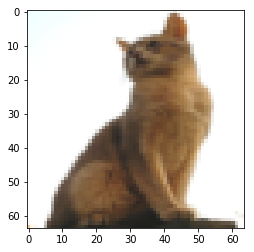

In [20]:
# Ejemplo de una imagen mal clasificada.
index = 6
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
clase=clases[int(d["Prediccion_prueba"][0,index])]
print ("Para y = " + str(test_set_y[0,index]) + ", el modelo dice que es una imagen de un \"" + clase +  "\".")

Grafiquemos la función de pérdida y los gradientes.

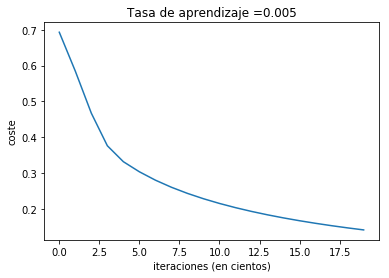

In [21]:
# Gráfica de la curva de aprendizaje (con costes)
costes = np.squeeze(d['Costes'])
plt.plot(costes)
plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')
plt.title("Tasa de aprendizaje =" + str(d["Tasa de aprendizaje"]))
plt.show()

**Interpretación**:
Se puede ver el coste decreciendo, demostrando que los parámetros están siendo aprendidos. Sin embargo, el modelo se podría entrenar aun más sobre el conjunto de entrenamiento. Intente aumentar el número de iteraciones arriba y vuelva a ejecutar el código. Podrá ver precisión del conjunto de entrnamiento aumenta, pero la del conjunto de prueba decrece. Este es evidencia del sobre-ajuste.

## 6 - Profundizando en el análisis ##

Ya tienes un primer modelo de clasificación de imagenes. Analizémoslo un poco más, como por ejemplo examinando distintos valores para la tasa de aprendizaje $\alpha$. 

#### Selección de la tasa de aprendizaje ####

**Nota**:
Para que el método del GD funcione de manera adecuada, se debe elegir la tasa de aprendiazaje de manera acertada. Esta tasa $\alpha$  determina qué tan rápido se actualizan los parámetros. Si la tasa es muy grande se puede "sobrepasar" el valor óptimo. Y de manera similar, si es muy pequeña se van a necesitar muchas iteraciones para converger a los mejores valores. Por ello la importancia de tener una tase de aprensizaje bien afinada.  

Ahora, comparemos la curva de aprendizaje de nuestro modelo con distintas elecciones para $\alpha$. Ejecute el código abajo. También puede intentar con valores distintos a los tres que estamos utilizando abajo para `learning_rates` y analize los resultados. 

La tasa de aprendizaje es: 0.01
Precisión de entrenamiento: 99.52153110047847 %
Precisión de prueba: 68.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.001
Precisión de entrenamiento: 88.99521531100478 %
Precisión de prueba: 64.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.0001
Precisión de entrenamiento: 68.42105263157895 %
Precisión de prueba: 36.0 %

-------------------------------------------------------



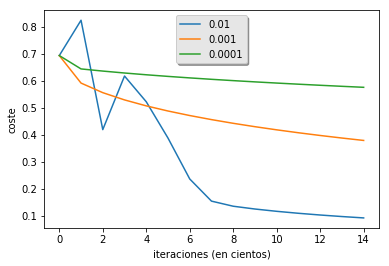

In [22]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("La tasa de aprendizaje es: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["Costes"]), label= str(models[str(i)]["Tasa de aprendizaje"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Discusión**: 
- Tasas diferentes obtienen costes diferentes y por lo tanto, predicciones diferentes.
- Si la tasa es muy grande (0.01), el coste puede oscilar arriba y abajo. Hasta puede diverger, aunque en este ejemplo $\alpha=0.01$ aun consigue un buen valor para el coste.  
- Un coste más bajo no implica un mejor modelo. Se debe chequear si hay una posibilidad de sobre-ajuste. Esto ocurre cuando la precisión de entrenamiento es mucho mayor que la precisión de prueba.
- En deep learning, es recomendable que se elija la tasa de aprendizaje que minimize la función de coste. Y si el modelo sobre-ajusta, se pueden probar otras técnicas (que veremos más adelante) para reducir dicho sobre-ajuste. 


## 7 - Pruebe con otras imagenes ##

Puede utilizar imagenes propias para ver los resultados de su modelo. Para ello, agregue su(s) imagen(es) al directorio de este cuaderno en la carpeta "images", cambie el nombre de la(s) imagen(es) en el siguiente código, y compruebe si el algoritmo acierta (1=gato, 0=no-gato). 

C:\Users\hernyatt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
C:\Users\hernyatt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


y = 0, el algoritmo predice que es una imagen de un "no-gato".


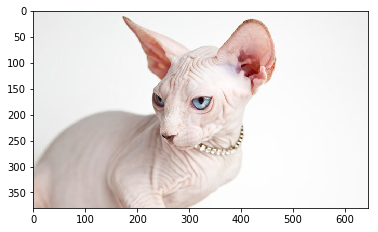

In [23]:
### EMPIEZE EL CÓDIGO AQUÍ ### (INTRODUZCA EL NOMBRE DE SU IMAGEN) 
my_image = "Sphynx.jpg"   # el nombre debe coincidir con el de su imagen
### TERMINE EL CÓDIGO AQUÍ ###

# Pre-procesamos la imagen
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(int(np.squeeze(my_predicted_image))) + ", el algoritmo predice que es una imagen de un \"" + clases[int(np.squeeze(my_predicted_image))]+  "\".")

Ahora puede intentar desarrollar su propio código modificado y compara los resultados. Intente mejorar los resultados obtenidos. Puede jugar con la tasa de aprendizaje, el número de iteraciones o distintos métodos de inicialización. También puede probar otras técnicas de pre-procesamiento, como el de estandarizar los datos, etc. 

<font color='blue'>
**Comentarios finales:**
1. Recuerde la importancia del pre-procesamiento de los datos.
2. Hemos implementado cada función de manera separada: initialize(), propagate(), optimize(). Y luego se construye el modelo: model().
3. La selección adecuada de la tasa de aprendizaje, al cual nos referimos como un "hiper-parámetro", puede hacer una gran diferencia en el algoritmo. Seguiremos viendo más ejemplos de esto en actividades futuras.

Algunas referencias:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c